# Travelling salesman problem

hill climbing und simulated annealing mit 2-opt

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

## Zufallsinstanzen

Wir erzeugen einfache Zufallsinstanzen. Dabei werden $N$ Städte gleichverteilt in einem Quadrat verteilt.

In [2]:
class EuclideanTSP_inst:
  """Euclidean instance of TSP.""" 
  def __init__(self,cities,name="generic instance"):
    """init expects a list of (x,y)-coordinate pairs, the cities"""
    self.name=name
    self.cities=cities

  def __len__(self):
    """Returns how many cities are contained in instance"""
    return len(self.cities)

  def dist(self,u,v):
    """The Euclidean distance of cities u=(u[0],u[1]) and v=(v[0],v[1])"""
    return math.sqrt((u[0]-v[0])**2+(u[1]-v[1])**2)

def uniform_rand_inst(N):
  """Generates random Euclidean instance of N cities that are put uniformly in 100x100 square"""
  cities=[(random.randint(0,99),random.randint(0,99)) for i in range(N)]
  return EuclideanTSP_inst(cities)

def random_tour(cities):
    """
    generates a random tour through citites
    the returned tour is simply a list of cities, where first and last is the same city
    """
    inner=cities[1:]
    start=cities[0]
    np.random.shuffle(inner)
    tour=[start]*(len(cities)+1)
    tour[1:-1]=inner
    return tour    

In [3]:
small_instance=uniform_rand_inst(5)
tour=random_tour(small_instance.cities)
tour

[(1, 59), (49, 99), (71, 36), (90, 53), (51, 50), (1, 59)]

Ein bisschen Code zur Veranschaulichung. Die Methode plot_tour_steps wird erst unten in der lokalen Suche interessant.

In [4]:
def plot_tour(tour):
    """simple code to plot a TSP tour"""
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    T=np.array(tour)
    plt.plot(T[:,0],T[:,1],c='b',zorder=0)
    plt.scatter(T[:,0],T[:,1],c='r',zorder=1)    
    
def plot_tour_steps(steps,instance,cols=4,save=False):
    """code to plot several local search steps"""
    rows=(len(steps)+cols-1)//cols
    size=4
    fig,axs=plt.subplots(rows,cols,figsize=(cols*size,rows*size))
    axs=axs.flat
    for tour_step,ax in zip(steps,axs):
        first,second,tour=tour_step
        ax.set_xticks([])
        ax.set_yticks([])
        T=np.array(tour)
        ax.plot(T[:,0],T[:,1],'b',zorder=0)
        ax.scatter(T[:,0],T[:,1],color='r',zorder=1)    
        if first is not None:
            if second is not None:
                ax.plot([T[first,0],T[first+1,0]],[T[first,1],T[first+1,1]],'r',linewidth=3,zorder=2)
                ax.plot([T[second-1,0],T[second,0]],[T[second-1,1],T[second,1]],'r',linewidth=3,zorder=2)
        ax.set_title("Länge: {:2.1f}".format(compute_length(tour,instance)))
    if save:
        plt.savefig("tsp_hill.png",dpi=300,bbox_inches='tight',pad_inches=0.1)
    plt.show()

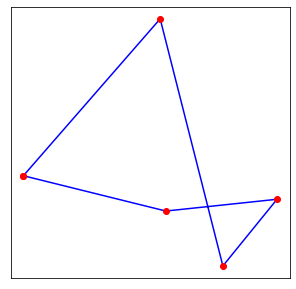

In [5]:
plot_tour(tour)

## Code für hill climbing 

Als erstes eine kleine Klasse, die nichts anderes tut, als sich die momentan beste Tour zu merken.

In [6]:
class Best_Tracker:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.best_cost=np.inf
        self.best=None
    
    def update(self,solution,cost):
        if cost<self.best_cost:
            self.best_cost=cost
            self.best=solution.copy()

In [7]:
def two_opt_savings(a,b,c,d,instance):
    """
    compute how much would be saved by performing a 2-opt move
    currently tour goes through a,b ... c,d
    after 2-opt move, tour goes through a,c ... b,d
    """
    dist=instance.dist
    return dist(a,b)+dist(c,d)-(dist(a,c)+dist(b,d))

def do_two_opt_move(first,second,tour):
    """
    actually perform 2-opt move
    where tour currently goes through ... first, successor of first, ..., predecessor of second, second, ...
    """
    middle=tour[first+1:second]
    middle.reverse()
    tour[first+1:second]=middle
    return tour

def tweak(tour,instance):
    """
    draw random 2-opt move and compute savings (if any)
    doesn't perform 2-opt move
    """
    n=len(tour)-1
    first=random.randint(0,n-3)
    second=random.randint(first+3,n)
    savings=two_opt_savings(tour[first],tour[first+1],tour[second-1],tour[second],instance)
    return savings,first,second

def compute_length(tour,instance):
    """computes length of tour"""
    return sum([instance.dist(tour[i],tour[i+1]) for i in range(len(tour)-1)])

def hill_climbing(tour,instance,tries=20,record=False):
    """
    we assume that tour is simply a list with first and last element identical
    record: if True, records 2-opt moves 
    """
    step_tracker=Best_Tracker()
    tour_steps=[]
    while True:  # try to improve tour until no longer possible
        step_tracker.reset()
        for _ in range(tries):  # find best 2-opt move 
            savings,first,second=tweak(tour,instance)
            step_tracker.update([first,second],-savings)
        if step_tracker.best_cost>=0: # we did not find any 2-opt move and will stop now
            if record:
                tour_steps.append((None,None,tour.copy()))
                return tour,compute_length(tour,instance),tour_steps
            return tour,compute_length(tour,instance)
        first,second=step_tracker.best  # this is the best 2-opt move we'd found
        if record:
            tour_steps.append((first,second,tour.copy()))
        do_two_opt_move(first,second,tour) # do the 2-opt move


Okay, probieren wir hill climbing aus. Dazu erzeugen wir zunächst eine Zufallsinstanz und auch eine Zufallstour als Starttour für das hill climbing.

Momentane Länge: 794.1


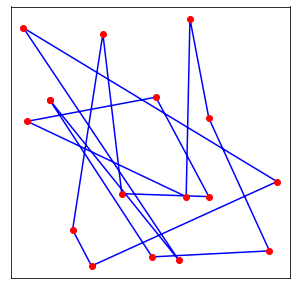

In [8]:
I=uniform_rand_inst(16)
tour=random_tour(I.cities)
plot_tour(tour)
print("Momentane Länge: {:.1f}".format(compute_length(tour,I)))

Momentane Länge: 362.2
hill climbing brauchte 12 Schritte


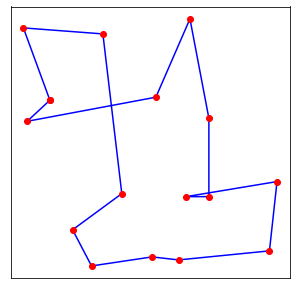

In [9]:
tour,length,steps=hill_climbing(tour,I,tries=50,record=True)
plot_tour(tour)
print("Momentane Länge: {:.1f}".format(compute_length(tour,I)))
print("hill climbing brauchte {} Schritte".format(len(steps)))

Sehr gut, eine substantielle Verbesserung. Wir können uns auch die einzelnen Schritte anzeigen lassen. Wir plotten hier einfach einmal die ersten 8 Schritte. Die Kanten des 2-opt-Schritts sind jeweils in rot markiert.

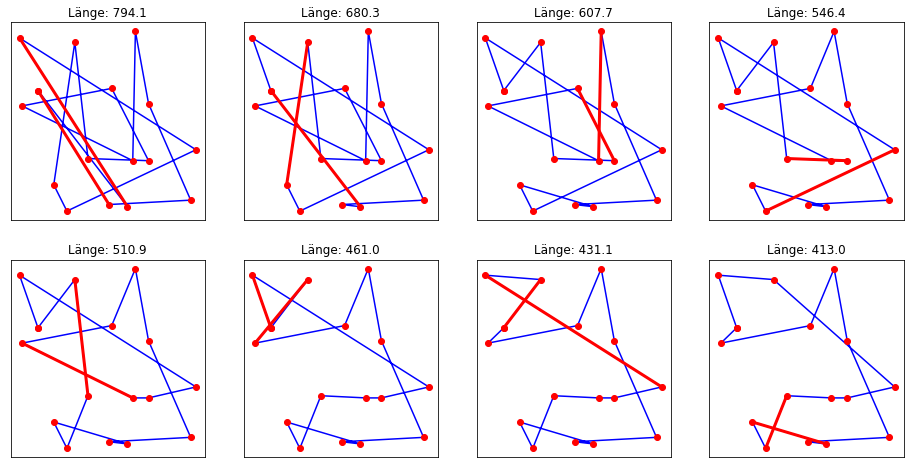

In [10]:
plot_tour_steps(steps[:8],I,save=True)

## Code für simulated annealing

In [11]:
def simulated_annealing(tour,instance,initial_temp=20,cooling_rate=0.99,total_steps=1000,record=False):
    """
    we assume that tour is simply a list with first and last element identical
    initial_temp: starting temperature
    cooling_rate: in each step we lower the temperature to cooling_rate*current temperature
    total_steps: number of iterations the algorithm performs
    record: whether to record each step
    """
    tracker=Best_Tracker()  # we keep track of the best tour we ever encounter
    tour_steps=[]
    temp=initial_temp   
    tracker.update(tour,0)  # current value is 0, savings are recorded as negative values
    length=compute_length(tour,instance)
    for step in range(total_steps):
        savings,first,second=tweak(tour,instance)
        tracker.update(tour,-savings)  # more negative is better
        if savings>0 or random.random()<=math.e**(savings/temp):  # accept if tour is shorter, alternatively accept with certain probability
            do_two_opt_move(first,second,tour)  # as we have accepted the move, actually perform it
            if record:
                length-=savings                     
                tour_steps.append((step,length,temp))
        temp=cooling_rate*temp
            
    if record:
        return tour,compute_length(tour,instance),tour_steps
    tour=tracker.best  # output best tour we ever encountered
    return tour,compute_length(tour,instance)


Probieren wir es aus, diesmal mit einer größeren Zufallsinstanz mit 100 Städten.

Momentane Länge: 5407.3


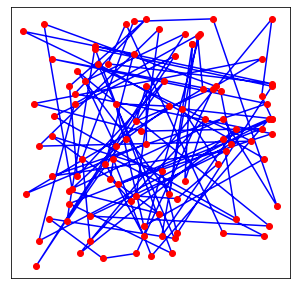

In [12]:
I=uniform_rand_inst(100)
tour=random_tour(I.cities)
plot_tour(tour)
print("Momentane Länge: {:.1f}".format(compute_length(tour,I)))

cooling_rate ist so gesetzt, dass die Abkühlung deutlich langsamer voran geht. Die Anzahl der Iterationen ist ebenfalls hoch gesetzt.

Momentane Länge: 975.4
simulated annealing akzeptierte 554 2-opt-Schritte


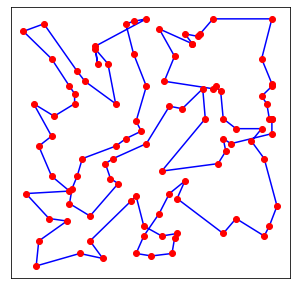

In [13]:
tour,length,steps=simulated_annealing(tour.copy(),I,cooling_rate=0.999,total_steps=10000,record=True)
plot_tour(tour)
print("Momentane Länge: {:.1f}".format(compute_length(tour,I)))
print("simulated annealing akzeptierte {} 2-opt-Schritte".format(len(steps)))

Um den Verlauf zu veranschaulichen, plotten wir Länge und Temperatur pro Schritt. 

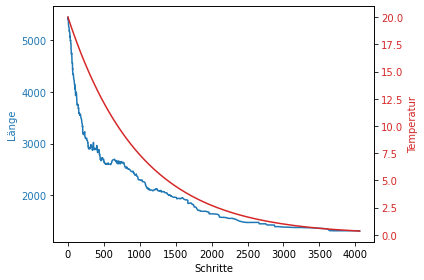

In [14]:
steps_array=np.array(steps)
last_step=500

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Schritte')
ax1.set_ylabel('Länge', color=color)
ax1.plot(steps_array[:last_step,0],steps_array[:last_step,1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Temperatur', color=color)  # we already handled the x-label with ax1
ax2.plot(steps_array[:last_step,0],steps_array[:last_step,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Man sieht, dass zu Beginn ab und zu ein 2-opt-Schritt akzeptiert wurde, der zu einer Verschlechterung führte -- ab etwa Schritt 2000 jedoch war dies nicht mehr der Fall. Tatsächlich zeigt der Kurvenverlauf jedoch, dass der Algorithmus noch nicht ideal eingestellt ist. Es würde wohl ausreichen, zunächst hill climbing laufen zu lassen und erst, wenn hill climbing keine weiteren Verbesserungen finden kann, simulated annealing. Momentan führt die Fähigkeit von simulated annealing auch einmal eine Verschlechterung in Kauf zu nehmen, global nicht zu einer Verbesserung.